In [71]:
# Import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss, TomekLinks
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.combine import SMOTETomek, SMOTEENN

from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

import joblib

# Import libraries to ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load the data
# Training data
traindata_cleaned = pd.read_csv('traindata_cleaned.csv')

# Testing data
testdata_cleaned = pd.read_csv('testdata_cleaned.csv')

In [4]:
testdata_cleaned.drop('TransactionID', axis=1, inplace=True)

## Continued from CCFD v.6

Determining the best sampling technique depends on the specific goals and priorities of your classification task. Different techniques have their advantages and disadvantages, and the choice may vary based on the nature of your data and the importance of precision, recall, and overall accuracy.

Here are a few considerations based on the provided table:

__Baseline:__

    High overall accuracy (0.9741).
    Balanced precision and recall for both classes.
    High F1-scores for both classes.

__SMOTE-Tomek:__

    High accuracy (0.9719).
    Good balance between precision and recall for both classes.
    High F1-scores for both classes.

__Tomek Links:__

    High accuracy (0.9732).
    Good balance between precision and recall for both classes.
    High F1-scores for both classes.

__SMOTE:__

    High accuracy (0.9724).
    Balanced precision and recall for Class 0.
    Slightly lower precision for Class 1 compared to other techniques.

In summary, both the Baseline and the combination of SMOTE-Tomek and Tomek Links seem to perform well in terms of overall accuracy and a balance between precision and recall for both classes. The choice between them may depend on other factors like computational efficiency, interpretability, or the specific goals of your classification task. It's recommended to consider a combination of metrics and possibly conduct further analysis or fine-tuning based on your specific requirements.

In [52]:
# Create an XGBoost classifier
xgb_model = XGBClassifier()

# Define hyperparameters and search space
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_child_weight': [1, 2, 3],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
}

# Use RandomizedSearchCV for hyperparameter search
randomized_search = RandomizedSearchCV(xgb_model, param_distributions=param_grid, n_iter=10, scoring='accuracy', cv=5)
randomized_search.fit(X_train, y_train)

# Print the best hyperparameters
print("Best Hyperparameters:", randomized_search.best_params_)

# Train the final model with the best hyperparameters on the entire training set
final_xgb_model = randomized_search.best_estimator_
final_xgb_model.fit(X_train, y_train)

# Evaluate the final model on a test set
accuracy_on_test = final_xgb_model.score(X_test, y_test)
print("Accuracy on Test Set:", accuracy_on_test)


Best Hyperparameters: {'subsample': 0.8, 'n_estimators': 300, 'min_child_weight': 1, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 1.0}
Accuracy on Test Set: 0.9704183036746014


In [53]:
# Create an XGBoost classifier
xgb_model = XGBClassifier()

# Define hyperparameters and search space
param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6],
    'min_child_weight': [1, 2, 3, 4],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3],
    'reg_alpha': [0, 0.1, 0.5, 1.0],
    'reg_lambda': [0, 0.1, 0.5, 1.0],
}

# Use RandomizedSearchCV for hyperparameter search
randomized_search = RandomizedSearchCV(xgb_model, param_distributions=param_grid, n_iter=50, scoring='accuracy', cv=5)
randomized_search.fit(X_resampled_tomek, y_resampled_tomek)

# Print the best hyperparameters
print("Best Hyperparameters:", randomized_search.best_params_)

Best Hyperparameters: {'subsample': 0.9, 'reg_lambda': 0.5, 'reg_alpha': 1.0, 'n_estimators': 300, 'min_child_weight': 1, 'max_depth': 6, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 0.9}


In [54]:
# Train the final XGBoost model with the best hyperparameters on the entire training set
final_xgb_model = randomized_search.best_estimator_
final_xgb_model.fit(X_resampled_tomek, y_resampled_tomek)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.1, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [55]:
# Make predictions on the validation set
y_pred_val = final_xgb_model.predict(X_val)

# Evaluate accuracy on the validation set
accuracy_on_val = accuracy_score(y_val, y_pred_val)
print("Accuracy on Validation Set:", accuracy_on_val)

# Evaluate additional metrics on the validation set
print("\nClassification Report on Validation Set:\n", classification_report(y_val, y_pred_val))

Accuracy on Validation Set: 0.9736075803096834

Classification Report on Validation Set:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99     19939
           1       0.92      0.73      0.81      1696

    accuracy                           0.97     21635
   macro avg       0.95      0.86      0.90     21635
weighted avg       0.97      0.97      0.97     21635



In [56]:
# Assuming X_test is your testing set

# Make predictions on the testing set
y_pred_test = final_xgb_model.predict(X_test)

# Evaluate accuracy on the testing set
accuracy_on_test = accuracy_score(y_test, y_pred_test)
print("Accuracy on Test Set:", accuracy_on_test)

# Evaluate additional metrics on the testing set
print("\nClassification Report on Test Set:\n", classification_report(y_test, y_pred_test))

Accuracy on Test Set: 0.9730067021030737

Classification Report on Test Set:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99     19888
           1       0.92      0.73      0.81      1747

    accuracy                           0.97     21635
   macro avg       0.95      0.86      0.90     21635
weighted avg       0.97      0.97      0.97     21635



In [57]:
# Save the final model to a file
joblib.dump(final_xgb_model, 'final_xgboost_model.joblib')

['final_xgboost_model.joblib']

In [58]:
from sklearn.model_selection import cross_val_score

# Perform cross-validation
cv_scores = cross_val_score(final_xgb_model, X_train, y_train, cv=30, scoring='accuracy')
print("Cross-Validation Scores:", cv_scores)

Cross-Validation Scores: [0.97073243 0.97365424 0.97152479 0.97335578 0.97360341]


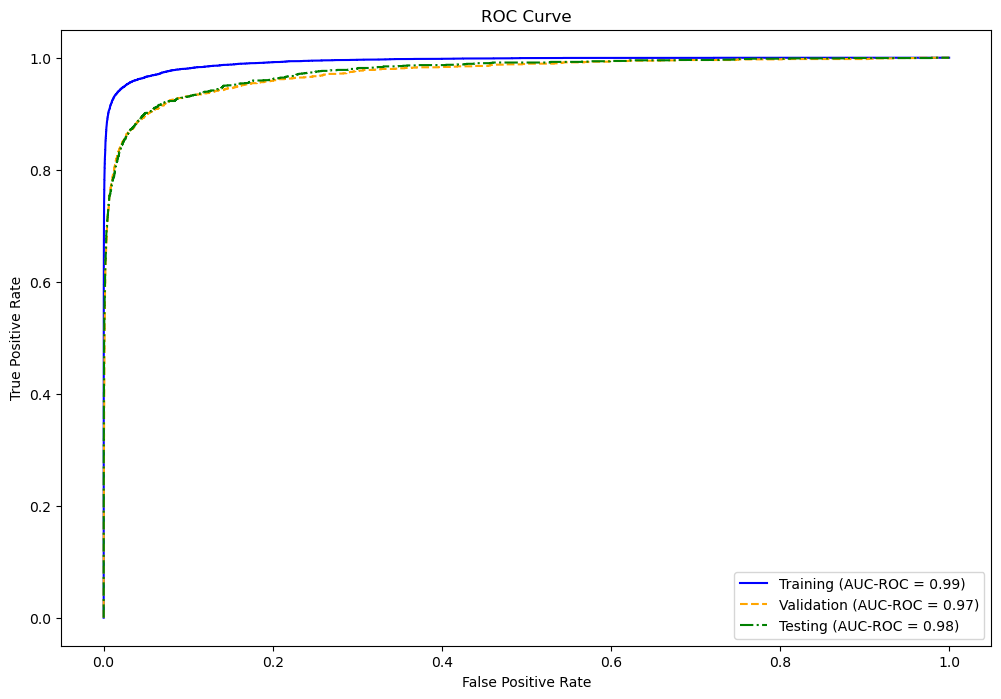

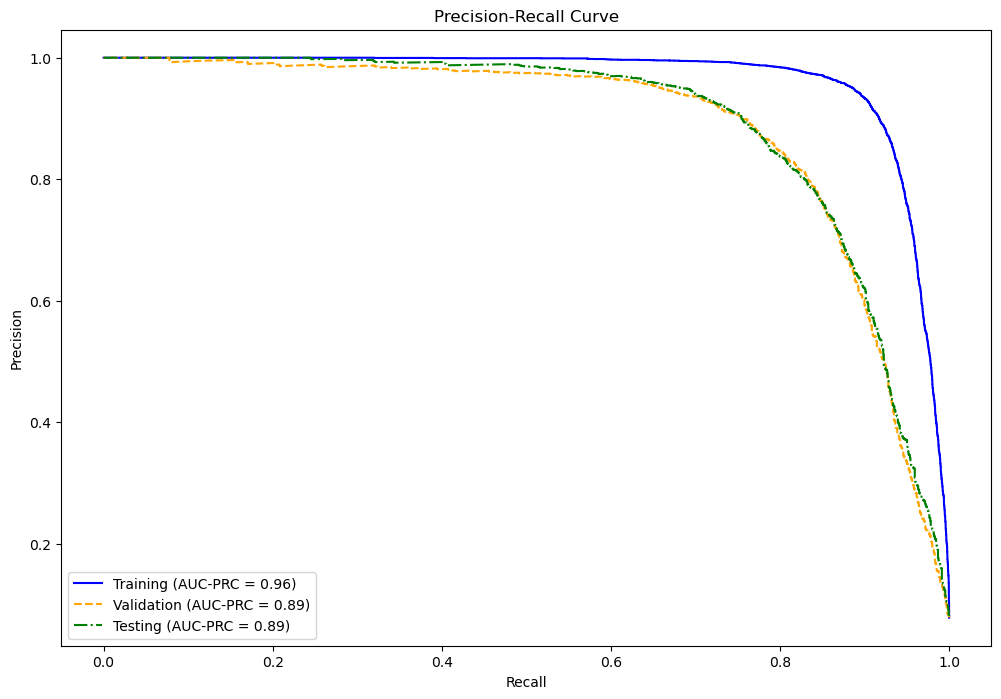

In [59]:
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve, precision_recall_curve

# Assuming final_xgb_model is the trained XGBoost model
# X_train, y_train, X_val, y_val, X_test, y_test are your training, validation, and testing sets

# Function to plot ROC curve
def plot_roc_curve(y_true, y_probs, label, color, linestyle):
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    auc_roc = roc_auc_score(y_true, y_probs)
    plt.plot(fpr, tpr, linestyle, color=color, label=f'{label} (AUC-ROC = {auc_roc:.2f})')

# Function to plot Precision-Recall curve
def plot_prc_curve(y_true, y_probs, label, color, linestyle):
    precision, recall, _ = precision_recall_curve(y_true, y_probs)
    auc_prc = average_precision_score(y_true, y_probs)
    plt.plot(recall, precision, linestyle, color=color, label=f'{label} (AUC-PRC = {auc_prc:.2f})')

# Predict probabilities on the training, validation, and testing sets
train_probs = final_xgb_model.predict_proba(X_train)[:, 1]
val_probs = final_xgb_model.predict_proba(X_val)[:, 1]
test_probs = final_xgb_model.predict_proba(X_test)[:, 1]

# Plot ROC and PRC curves
plt.figure(figsize=(12, 8))

plot_roc_curve(y_train, train_probs, 'Training', 'blue', '-')
plot_roc_curve(y_val, val_probs, 'Validation', 'orange', '--')
plot_roc_curve(y_test, test_probs, 'Testing', 'green', '-.')

plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

plt.figure(figsize=(12, 8))

plot_prc_curve(y_train, train_probs, 'Training', 'blue', '-')
plot_prc_curve(y_val, val_probs, 'Validation', 'orange', '--')
plot_prc_curve(y_test, test_probs, 'Testing', 'green', '-.')

plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

C:\Users\dsouzag\AppData\Local\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-error:0.07800	validation_0-logloss:0.27247	validation_1-error:0.07839	validation_1-logloss:0.27367
[1]	validation_0-error:0.07800	validation_0-logloss:0.25224	validation_1-error:0.07839	validation_1-logloss:0.25413
[2]	validation_0-error:0.07800	validation_0-logloss:0.23564	validation_1-error:0.07839	validation_1-logloss:0.23818
[3]	validation_0-error:0.07800	validation_0-logloss:0.22151	validation_1-error:0.07839	validation_1-logloss:0.22427
[4]	validation_0-error:0.07798	validation_0-logloss:0.20976	validation_1-error:0.07839	validation_1-logloss:0.21276
[5]	validation_0-error:0.05664	validation_0-logloss:0.19902	validation_1-error:0.05736	validation_1-logloss:0.20227
[6]	validation_0-error:0.04988	validation_0-logloss:0.19001	validation_1-error:0.05168	validation_1-logloss:0.19334
[7]	validation_0-error:0.04771	validation_0-logloss:0.18245	validation_1-error:0.04969	validation_1-logloss:0.18595
[8]	validation_0-error:0.04495	validation_0-logloss:0.17527	validation_1

[71]	validation_0-error:0.02832	validation_0-logloss:0.08912	validation_1-error:0.03351	validation_1-logloss:0.10381
[72]	validation_0-error:0.02823	validation_0-logloss:0.08873	validation_1-error:0.03351	validation_1-logloss:0.10361
[73]	validation_0-error:0.02808	validation_0-logloss:0.08831	validation_1-error:0.03356	validation_1-logloss:0.10336
[74]	validation_0-error:0.02794	validation_0-logloss:0.08785	validation_1-error:0.03337	validation_1-logloss:0.10300
[75]	validation_0-error:0.02782	validation_0-logloss:0.08751	validation_1-error:0.03333	validation_1-logloss:0.10277
[76]	validation_0-error:0.02781	validation_0-logloss:0.08724	validation_1-error:0.03319	validation_1-logloss:0.10261
[77]	validation_0-error:0.02768	validation_0-logloss:0.08685	validation_1-error:0.03296	validation_1-logloss:0.10231
[78]	validation_0-error:0.02749	validation_0-logloss:0.08626	validation_1-error:0.03277	validation_1-logloss:0.10196
[79]	validation_0-error:0.02742	validation_0-logloss:0.08594	val

[141]	validation_0-error:0.02251	validation_0-logloss:0.07101	validation_1-error:0.03028	validation_1-logloss:0.09285
[142]	validation_0-error:0.02238	validation_0-logloss:0.07082	validation_1-error:0.03037	validation_1-logloss:0.09270
[143]	validation_0-error:0.02231	validation_0-logloss:0.07053	validation_1-error:0.03032	validation_1-logloss:0.09253
[144]	validation_0-error:0.02226	validation_0-logloss:0.07033	validation_1-error:0.03028	validation_1-logloss:0.09238
[145]	validation_0-error:0.02218	validation_0-logloss:0.07012	validation_1-error:0.03037	validation_1-logloss:0.09225
[146]	validation_0-error:0.02218	validation_0-logloss:0.07001	validation_1-error:0.03032	validation_1-logloss:0.09220
[147]	validation_0-error:0.02211	validation_0-logloss:0.06985	validation_1-error:0.03032	validation_1-logloss:0.09207
[148]	validation_0-error:0.02209	validation_0-logloss:0.06978	validation_1-error:0.03028	validation_1-logloss:0.09203
[149]	validation_0-error:0.02199	validation_0-logloss:0.

[211]	validation_0-error:0.01812	validation_0-logloss:0.05926	validation_1-error:0.02843	validation_1-logloss:0.08672
[212]	validation_0-error:0.01810	validation_0-logloss:0.05913	validation_1-error:0.02829	validation_1-logloss:0.08667
[213]	validation_0-error:0.01806	validation_0-logloss:0.05905	validation_1-error:0.02829	validation_1-logloss:0.08661
[214]	validation_0-error:0.01801	validation_0-logloss:0.05892	validation_1-error:0.02843	validation_1-logloss:0.08660
[215]	validation_0-error:0.01796	validation_0-logloss:0.05872	validation_1-error:0.02847	validation_1-logloss:0.08650
[216]	validation_0-error:0.01784	validation_0-logloss:0.05855	validation_1-error:0.02843	validation_1-logloss:0.08638
[217]	validation_0-error:0.01781	validation_0-logloss:0.05846	validation_1-error:0.02852	validation_1-logloss:0.08634
[218]	validation_0-error:0.01770	validation_0-logloss:0.05833	validation_1-error:0.02861	validation_1-logloss:0.08630
[219]	validation_0-error:0.01763	validation_0-logloss:0.

[281]	validation_0-error:0.01451	validation_0-logloss:0.05027	validation_1-error:0.02750	validation_1-logloss:0.08288
[282]	validation_0-error:0.01449	validation_0-logloss:0.05013	validation_1-error:0.02741	validation_1-logloss:0.08280
[283]	validation_0-error:0.01449	validation_0-logloss:0.04997	validation_1-error:0.02732	validation_1-logloss:0.08272
[284]	validation_0-error:0.01446	validation_0-logloss:0.04987	validation_1-error:0.02736	validation_1-logloss:0.08268
[285]	validation_0-error:0.01443	validation_0-logloss:0.04978	validation_1-error:0.02732	validation_1-logloss:0.08264
[286]	validation_0-error:0.01430	validation_0-logloss:0.04964	validation_1-error:0.02722	validation_1-logloss:0.08251
[287]	validation_0-error:0.01412	validation_0-logloss:0.04946	validation_1-error:0.02727	validation_1-logloss:0.08239
[288]	validation_0-error:0.01413	validation_0-logloss:0.04941	validation_1-error:0.02732	validation_1-logloss:0.08237
[289]	validation_0-error:0.01408	validation_0-logloss:0.

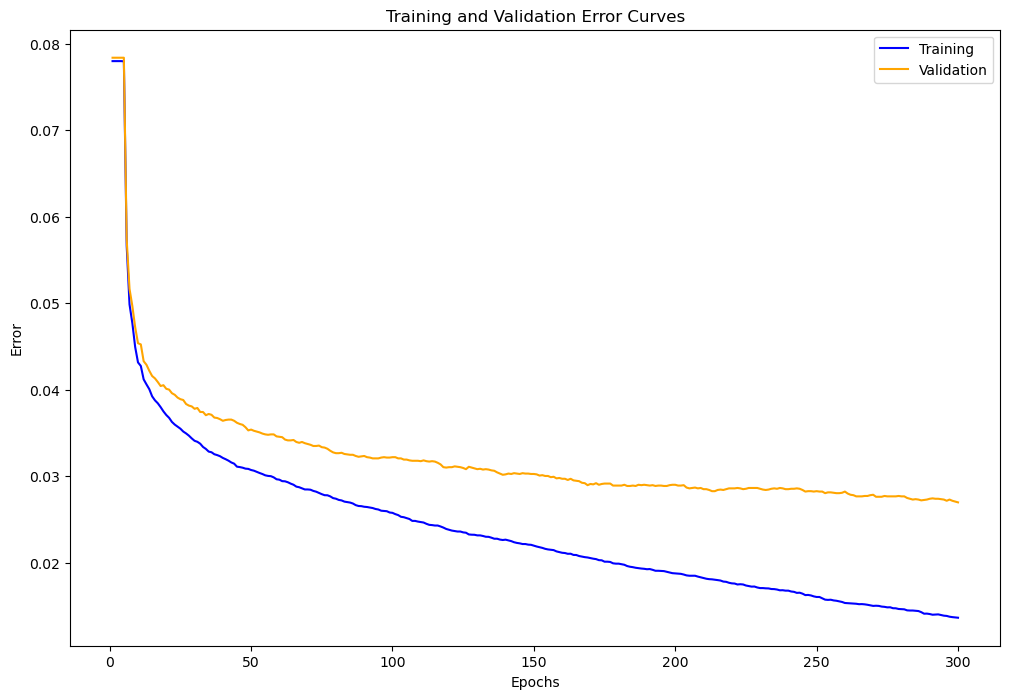

In [60]:
# Train the model with eval_set for monitoring
evals = [(X_train, y_train), (X_val, y_val)]
final_xgb_model.fit(X_train, y_train, eval_metric=["error", "logloss"], eval_set=evals, verbose=True)

# Plot Training and Validation Accuracy Curves
epochs = range(1, len(final_xgb_model.evals_result()['validation_0']['error']) + 1)

plt.figure(figsize=(12, 8))
plt.plot(epochs, final_xgb_model.evals_result()['validation_0']['error'], label='Training', color='blue')
plt.plot(epochs, final_xgb_model.evals_result()['validation_1']['error'], label='Validation', color='orange')
plt.title('Training and Validation Error Curves')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.legend()
plt.show()

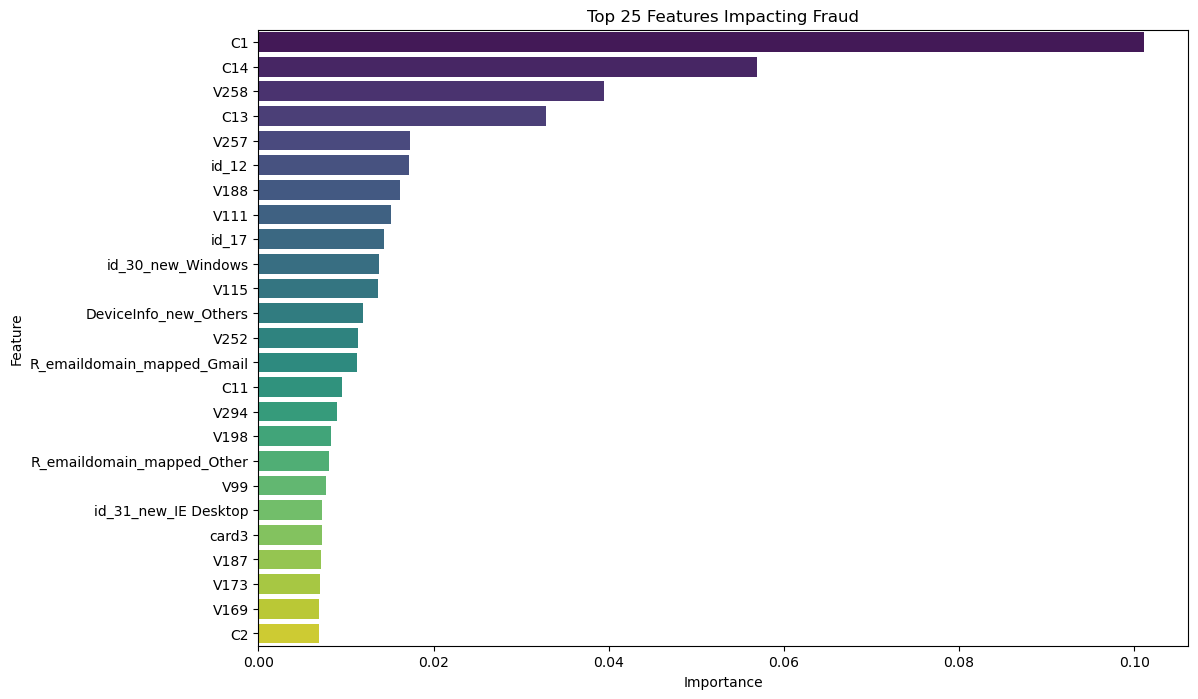

In [70]:
# Get feature importance scores
feature_importance = final_xgb_model.feature_importances_

# Create a DataFrame to associate original feature names with their importance scores
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importance})

# Sort the features by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot the top N features
top_n = 25  # Set the number of top features to display
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(top_n), palette='viridis')
plt.title(f'Top {top_n} Features Impacting Fraud')
plt.show()

In [ ]:
# Create a confusion matrix
cf_mat_smoteenn = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(4, 4))
sns.set(font_scale=0.8)
sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=xgb_classifier.classes_, yticklabels=xgb_classifier.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix using XGBoost Classifier\n")
plt.show()